<h1 style='color:#205be6' align='center'>Predicting Home Prices in Perth using Several Regression Models.</h1>

Link for the Dataset: https://www.kaggle.com/syuzai/perth-house-prices

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score

matplotlib.rcParams["figure.figsize"] = (12, 12)
import warnings
warnings.filterwarnings(action='ignore')

<h2 style='color:#205be6'>Load data into a Data Frame</h2>

In [2]:
df1 = pd.read_csv('perth_house_data.csv')

# head(3) will print first 3 rows of the calling dataset
df1.head(3) 

,ADDRESS,SUBURB,PRICE,BEDROOMS,BATHROOMS,GARAGE,LAND_AREA,FLOOR_AREA,BUILD_YEAR,CBD_DIST,NEAREST_STN,NEAREST_STN_DIST,DATE_SOLD,POSTCODE,LATITUDE,LONGITUDE,NEAREST_SCH,NEAREST_SCH_DIST,NEAREST_SCH_RANK
0,1 Acorn Place,South Lake,565000,4,2,2.0,600,160,2003.0,18300,Cockburn Central Station,1800,09-2018\r,6164,-32.115900,115.842450,LAKELAND SENIOR HIGH SCHOOL,0.828339,NaN
1,1 Addis Way,Wandi,365000,3,2,2.0,351,139,2013.0,26900,Kwinana Station,4900,02-2019\r,6167,-32.193470,115.859553,ATWELL COLLEGE,5.524324,129.0
2,1 Ainsley Court,Camillo,287000,3,1,1.0,719,86,1979.0,22600,Challis Station,1900,06-2015\r,6111,-32.120578,115.993579,KELMSCOTT SENIOR HIGH SCHOOL,1.649178,113.0


<h2 style='color:#205be6'>Analyze the Data</h2>

In [3]:
# see number of rows, number of columns

df1.shape

(33656, 19)

In [4]:
# see columns names

df1.columns

Index(['ADDRESS', 'SUBURB', 'PRICE', 'BEDROOMS', 'BATHROOMS', 'GARAGE',
       'LAND_AREA', 'FLOOR_AREA', 'BUILD_YEAR', 'CBD_DIST', 'NEAREST_STN',
       'NEAREST_STN_DIST', 'DATE_SOLD', 'POSTCODE', 'LATITUDE', 'LONGITUDE',
       'NEAREST_SCH', 'NEAREST_SCH_DIST', 'NEAREST_SCH_RANK'],
      dtype='object')

#### Column Description

* ADDRESS : Physical address of the property    <br />
* SUBURB : Specific locality in Perth; a list of all Perth suburb can be found here    <br />
* PRICE : Price at which a property was sold (AUD)    <br />
* BEDROOMS : Number of bedrooms    <br />
* BATHROOMS : Number of bathrooms    <br />
* GARAGE : Number of garage places    <br />
* LAND_AREA : Total land area (Square Meters)    <br />
* FLOOR_AREA : Internal floor area (Square Meters)    <br />
* BUILD_YEAR : Year in which the property was built    <br />
* CBD_DIST : Distance from the centre of Perth (Meters)    <br />
* NEAREST_STN : The nearest public transport station from the property    <br />
* NEAREST_STN_DIST : The nearest station distance (Meters)    <br />
* DATE_SOLD : Month & year in which the property was sold    <br />
* POSTCODE : Local Area Identifier    <br />
* LATITUDE : Geographic Location (lat) of ADDRESS    <br />
* LONGITUDE : Geographic Location (long) of ADDRESS    <br />
* NEAREST_SCH : Location of the nearest School    <br />
* NEAREST_SCH_DIST : Distance to the nearest school (Kilo Meters)    <br />
* NEAREST_SCH_RANK : Ranking of the nearest school    <br />

<p style='color:#d61515'>Since ADDRESS, NEAREST_STN, DATE_SOLD, POSTCODE, LATITUDE, LONGITUDE and NEAREST_SCH are not that much important when buying a new house, those features will be dropped when data cleaning.</p>

In [5]:
# See data types of the Columns

df1.dtypes

ADDRESS              object
SUBURB               object
PRICE                 int64
BEDROOMS              int64
BATHROOMS             int64
GARAGE              float64
LAND_AREA             int64
FLOOR_AREA            int64
BUILD_YEAR          float64
CBD_DIST              int64
NEAREST_STN          object
NEAREST_STN_DIST      int64
DATE_SOLD            object
POSTCODE              int64
LATITUDE            float64
LONGITUDE           float64
NEAREST_SCH          object
NEAREST_SCH_DIST    float64
NEAREST_SCH_RANK    float64
dtype: object

<p style='color:#21c43a'>GARAGE, BUILD_YEAR and NEAREST_SCH_RANK features should be integer numbers. But now they are in float data type. Therefore, they will be converted into integers when data cleaning.</p>

In [6]:
# See how many unique values in the each 'Categorical Column' (Columns that have values other than numbers)

print("Column Name   Unique Values")
print("-----------   -------------")
for column in df1.columns:
    if(df1[column].dtypes != df1['GARAGE'].dtypes and df1[column].dtypes != df1['PRICE'].dtypes):
        print(column + ': \t' + str(df1[column].nunique()))


Column Name   Unique Values
-----------   -------------
ADDRESS: 	33566
SUBURB: 	321
NEAREST_STN: 	68
DATE_SOLD: 	350
NEAREST_SCH: 	160


<p style='color:#d61515'>By seeing above numbers of unique categorical values in each column, we can identify it is hard to work with those columns and also only SUBURB of above features will be used to train the model since SUBURB is an important factor to consider when buying houses. Others will be dropped when data cleaning. Specially almost all values of the ADDRESS column are unique. These kind of columns called High-cardinality columns which are not suitable in regression.</p>

In [7]:
# See how many null values in each column

df1.isnull().sum()

ADDRESS                 0
SUBURB                  0
PRICE                   0
BEDROOMS                0
BATHROOMS               0
GARAGE               2478
LAND_AREA               0
FLOOR_AREA              0
BUILD_YEAR           3155
CBD_DIST                0
NEAREST_STN             0
NEAREST_STN_DIST        0
DATE_SOLD               0
POSTCODE                0
LATITUDE                0
LONGITUDE               0
NEAREST_SCH             0
NEAREST_SCH_DIST        0
NEAREST_SCH_RANK    10952
dtype: int64

<p style='color:#d61515'>NEAREST_SCH_RANK has almost one third of null values. Therefore, that column need be dropped. Otherwise it will lead to inaccuracy of the model when data cleaning.</p>

<p style='color:#21c43a'> GARAGE and BUILD_YEAR also have null values. Since those are not that much significant amount, those cells will be replaced with the median values of the particular column when data cleaning.</p>

In [8]:
# See the Correlation Matrix (Linear Correlation)
df1.corr()

,PRICE,BEDROOMS,BATHROOMS,GARAGE,LAND_AREA,FLOOR_AREA,BUILD_YEAR,CBD_DIST,NEAREST_STN_DIST,POSTCODE,LATITUDE,LONGITUDE,NEAREST_SCH_DIST,NEAREST_SCH_RANK
PRICE,1.000000,0.252637,0.377133,0.134343,0.056855,0.548497,-0.157218,-0.354327,-0.095089,-0.171553,0.053041,-0.183734,-0.021941,-0.461991
BEDROOMS,0.252637,1.000000,0.555702,0.194197,0.051223,0.536926,0.229019,0.124654,0.102203,0.010601,0.021967,-0.015170,0.092391,0.024461
BATHROOMS,0.377133,0.555702,1.000000,0.186801,0.027059,0.555843,0.339594,0.033053,0.037068,-0.041374,0.051411,-0.093817,0.060734,-0.096024
GARAGE,0.134343,0.194197,0.186801,1.000000,0.059211,0.201541,0.040371,0.046244,0.110527,0.028005,-0.016416,0.091270,0.099654,0.021863
LAND_AREA,0.056855,0.051223,0.027059,0.059211,1.000000,0.073836,0.002063,0.133262,0.233023,0.042070,-0.014389,0.151255,0.286964,0.048758
FLOOR_AREA,0.548497,0.536926,0.555843,0.201541,0.073836,1.000000,0.226872,0.022687,0.106527,-0.050658,0.043555,-0.046625,0.120048,-0.145502
BUILD_YEAR,-0.157218,0.229019,0.339594,0.040371,0.002063,0.226872,1.000000,0.270110,0.103350,0.044095,0.045463,-0.059047,0.108719,0.158639
CBD_DIST,-0.354327,0.124654,0.033053,0.046244,0.133262,0.022687,0.270110,1.000000,0.446496,0.255801,-0.196813,-0.060097,0.377118,0.328703
NEAREST_STN_DIST,-0.095089,0.102203,0.037068,0.110527,0.233023,0.106527,0.103350,0.446496,1.000000,0.204347,0.037174,0.496924,0.634712,0.189571
POSTCODE,-0.171553,0.010601,-0.041374,0.028005,0.042070,-0.050658,0.044095,0.255801,0.204347,1.000000,-0.642643,0.173918,0.128424,0.192768


<AxesSubplot:>

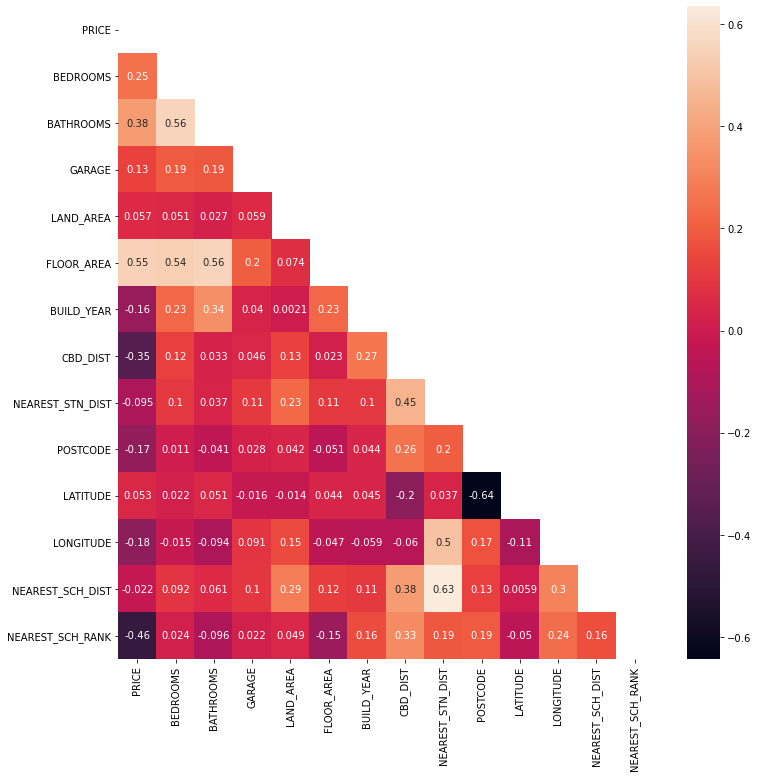

In [9]:
# Plot the Correlation Matrix (Linear Correlation)

matrix = np.triu(df1.corr()) # in order to produce only the lower part of the matrix
sns.heatmap(df1.corr(), annot = True, mask=matrix)

<p style='color:#176fd4'> Above Correlation Matrix shows co-relation between numerical features only. There are no categorical variables there. And also it depicts only lower part of the matrix (because this is a Symmetric Matrix). And we can see the correlation values are in between -0.65 and +0.6. It means there are no strong co-related features in this data. Therefore, it is not needed to remove features based on the co-relations. </p>

<h2 style='color:#205be6'>Data Cleaning</h2>

In [10]:
# Drop features that are not required to build our model and create new data frame 'df2'

df2 = df1.drop(['ADDRESS', 'NEAREST_STN', 'DATE_SOLD', 'POSTCODE', 'LATITUDE', 'LONGITUDE', 'NEAREST_SCH', 'NEAREST_SCH_RANK'],
               axis='columns')
df2.head(3)

,SUBURB,PRICE,BEDROOMS,BATHROOMS,GARAGE,LAND_AREA,FLOOR_AREA,BUILD_YEAR,CBD_DIST,NEAREST_STN_DIST,NEAREST_SCH_DIST
0,South Lake,565000,4,2,2.0,600,160,2003.0,18300,1800,0.828339
1,Wandi,365000,3,2,2.0,351,139,2013.0,26900,4900,5.524324
2,Camillo,287000,3,1,1.0,719,86,1979.0,22600,1900,1.649178


In [11]:
# Fill missing values of 'GARAGE' and 'BUILD_YEAR' columns

df2['BUILD_YEAR'] = df2['BUILD_YEAR'].fillna(df2['BUILD_YEAR'].median())
df2['GARAGE'] = df2['GARAGE'].fillna(df2['GARAGE'].median())

df2.head(3)

,SUBURB,PRICE,BEDROOMS,BATHROOMS,GARAGE,LAND_AREA,FLOOR_AREA,BUILD_YEAR,CBD_DIST,NEAREST_STN_DIST,NEAREST_SCH_DIST
0,South Lake,565000,4,2,2.0,600,160,2003.0,18300,1800,0.828339
1,Wandi,365000,3,2,2.0,351,139,2013.0,26900,4900,5.524324
2,Camillo,287000,3,1,1.0,719,86,1979.0,22600,1900,1.649178


In [12]:
# See again how many null values in each column. But now we deal with 'df2'

df2.isnull().sum()

SUBURB              0
PRICE               0
BEDROOMS            0
BATHROOMS           0
GARAGE              0
LAND_AREA           0
FLOOR_AREA          0
BUILD_YEAR          0
CBD_DIST            0
NEAREST_STN_DIST    0
NEAREST_SCH_DIST    0
dtype: int64

In [13]:
# see number of rows, number of columns

df2.shape

(33656, 11)

<h2 style='color:#205be6'>Detect and Remove Outliers Using IQR (Inter Quartile Range)</h2>

In [14]:
# Get the statistics per each column

df2.describe()

,PRICE,BEDROOMS,BATHROOMS,GARAGE,LAND_AREA,FLOOR_AREA,BUILD_YEAR,CBD_DIST,NEAREST_STN_DIST,NEAREST_SCH_DIST
count,3.365600e+04,33656.000000,33656.000000,33656.000000,33656.000000,33656.000000,33656.000000,33656.000000,33656.000000,33656.000000
mean,6.370720e+05,3.659110,1.823063,2.185197,2740.644016,183.501545,1990.202668,19777.374465,4523.371494,1.815268
std,3.558256e+05,0.752038,0.587427,1.315041,16693.513215,72.102982,20.017053,11364.415413,4495.064024,1.746000
min,5.100000e+04,1.000000,1.000000,1.000000,61.000000,1.000000,1868.000000,681.000000,46.000000,0.070912
25%,4.100000e+05,3.000000,1.000000,2.000000,503.000000,130.000000,1980.000000,11200.000000,1800.000000,0.880568
50%,5.355000e+05,4.000000,2.000000,2.000000,682.000000,172.000000,1995.000000,17500.000000,3200.000000,1.345520
75%,7.600000e+05,4.000000,2.000000,2.000000,838.000000,222.250000,2004.000000,26600.000000,5300.000000,2.097225
max,2.440000e+06,10.000000,16.000000,99.000000,999999.000000,870.000000,2017.000000,59800.000000,35500.000000,23.254372


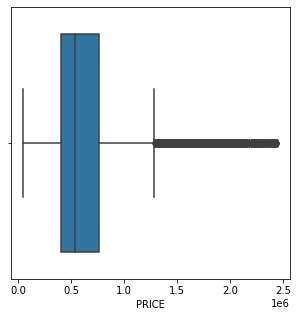

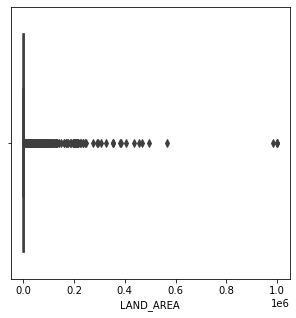

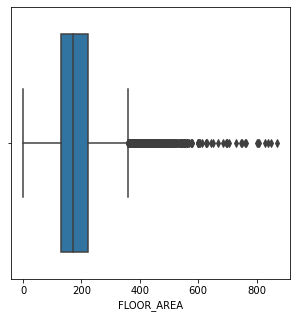

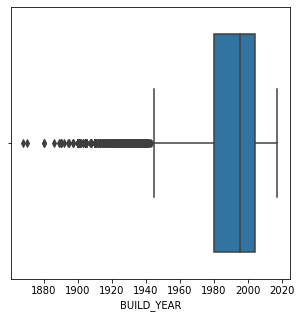

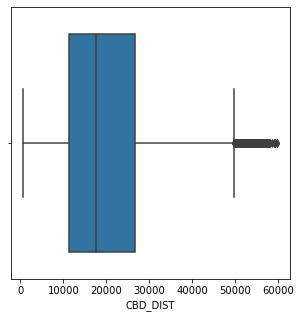

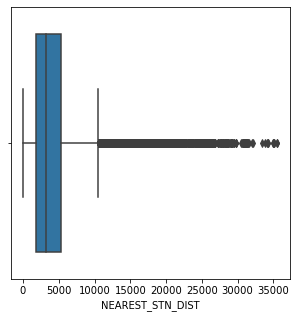

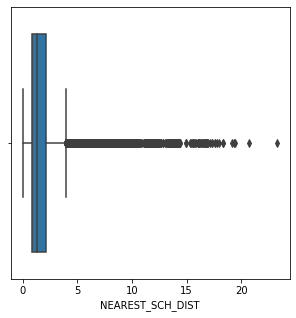

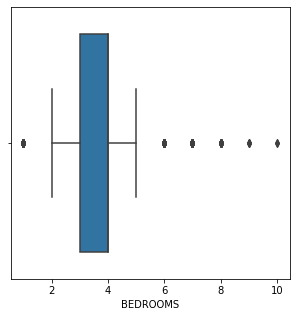

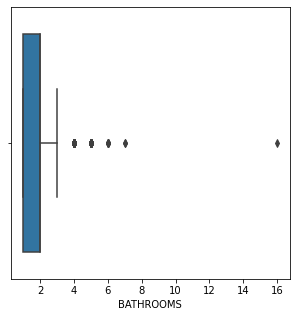

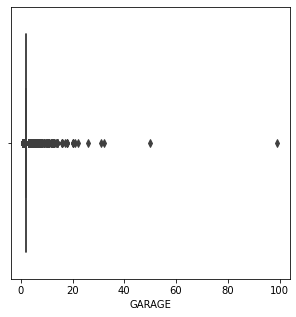

In [15]:
# Boxplot for each column


plt.figure(figsize=(5, 5))
sns.boxplot(x=df2['PRICE']);

plt.figure(figsize=(5, 5))
sns.boxplot(x=df2['LAND_AREA']);

plt.figure(figsize=(5, 5))
sns.boxplot(x=df2['FLOOR_AREA']);

plt.figure(figsize=(5, 5))
sns.boxplot(x=df2['BUILD_YEAR']);

plt.figure(figsize=(5, 5))
sns.boxplot(x=df2['CBD_DIST']);

plt.figure(figsize=(5, 5))
sns.boxplot(x=df2['NEAREST_STN_DIST']);

plt.figure(figsize=(5, 5))
sns.boxplot(x=df2['NEAREST_SCH_DIST']);

plt.figure(figsize=(5, 5))
sns.boxplot(x=df2['BEDROOMS']);

plt.figure(figsize=(5, 5))
sns.boxplot(x=df2['BATHROOMS']);

plt.figure(figsize=(5, 5))
sns.boxplot(x=df2['GARAGE']);

In [16]:
# Remove outliers of all columns and assign to new data freame called 'df3'

cols = ['PRICE', 'LAND_AREA', 'FLOOR_AREA', 'BEDROOMS', 'BATHROOMS', 'BUILD_YEAR', 'CBD_DIST', 'NEAREST_STN_DIST', 'NEAREST_SCH_DIST', 'GARAGE']

Q1 = df2[cols].quantile(0.25)
Q3 = df2[cols].quantile(0.75)
IQR = Q3 - Q1

df3 = df2[~((df2[cols] < (Q1 - 1.5 * IQR)) | (df2[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]


In [17]:
# See the houses there are more bathrooms than bedrooms count + 2, because it is uncommon and need to be removed

df3[df3.BATHROOMS > df3.BEDROOMS + 2]

,SUBURB,PRICE,BEDROOMS,BATHROOMS,GARAGE,LAND_AREA,FLOOR_AREA,BUILD_YEAR,CBD_DIST,NEAREST_STN_DIST,NEAREST_SCH_DIST


In [18]:
# See the houses there are garages more than 3, because it is uncommon and need to be removed

df3[df3.GARAGE > 3]

,SUBURB,PRICE,BEDROOMS,BATHROOMS,GARAGE,LAND_AREA,FLOOR_AREA,BUILD_YEAR,CBD_DIST,NEAREST_STN_DIST,NEAREST_SCH_DIST


In [19]:
df3.shape

(16734, 11)

<h2 style='color:#205be6'>Data Standardization and Normalization</h2>

In [20]:
# 'NEAREST_SCH_DIST' column is in 'Kilo Meters' and other distances are in 'Meters'. And the Standard unit is 'Meters'. 
# Therefore, 'NEAREST_SCH_DIST' column need to be converted in to 'Meters' 

df4 = df3.copy()

df4['NEAREST_SCH_DIST'] = df3['NEAREST_SCH_DIST'] * 1000

df4.head()

,SUBURB,PRICE,BEDROOMS,BATHROOMS,GARAGE,LAND_AREA,FLOOR_AREA,BUILD_YEAR,CBD_DIST,NEAREST_STN_DIST,NEAREST_SCH_DIST
0,South Lake,565000,4,2,2.0,600,160,2003.0,18300,1800,828.338552
3,Bellevue,255000,2,1,2.0,651,59,1953.0,17900,3600,1571.400937
4,Lockridge,325000,4,1,2.0,466,131,1998.0,11200,2000,1514.921629
6,Hilbert,400000,3,2,2.0,386,132,2014.0,28200,3700,2485.730857
7,Waikiki,370000,4,2,2.0,468,158,2013.0,41700,1100,491.573138


In [21]:
#Convert GARAGE and BUILD_YEAR into integers.

df4['GARAGE'] = df4['GARAGE'].astype('int64')
df4['BUILD_YEAR'] = df4['BUILD_YEAR'].astype('int64')

# In this dataset all the other distances are in Integer datatype. 
# Therefore, it is better to convert 'NEAREST_SCH_DIST' column in to 'Meters' as per the consistency.

df4['NEAREST_SCH_DIST'] = df4['NEAREST_SCH_DIST'].astype('int64')

df4.dtypes

SUBURB              object
PRICE                int64
BEDROOMS             int64
BATHROOMS            int64
GARAGE               int64
LAND_AREA            int64
FLOOR_AREA           int64
BUILD_YEAR           int64
CBD_DIST             int64
NEAREST_STN_DIST     int64
NEAREST_SCH_DIST     int64
dtype: object

In [22]:
# Get all numerical values to a range between 0 and 1
# divide all values from its column's maximum number

df5 = df4.copy()

df5['PRICE'] = df4['PRICE'] / df4['PRICE'].max()
df5['BEDROOMS'] = df4['BEDROOMS'] / df4['BEDROOMS'].max()
df5['BATHROOMS'] = df4['BATHROOMS'] / df4['BATHROOMS'].max()
df5['GARAGE'] = df4['GARAGE'] / df4['GARAGE'].max()
df5['LAND_AREA'] = df4['LAND_AREA'] / df4['LAND_AREA'].max()
df5['FLOOR_AREA'] = df4['FLOOR_AREA'] / df4['FLOOR_AREA'].max()
df5['BUILD_YEAR'] = df4['BUILD_YEAR'] / df4['BUILD_YEAR'].max()
df5['CBD_DIST'] = df4['CBD_DIST'] / df4['CBD_DIST'].max()
df5['NEAREST_STN_DIST'] = df4['NEAREST_STN_DIST'] / df4['NEAREST_STN_DIST'].max()
df5['NEAREST_SCH_DIST'] = df4['NEAREST_SCH_DIST'] / df4['NEAREST_SCH_DIST'].max()

df5

,SUBURB,PRICE,BEDROOMS,BATHROOMS,GARAGE,LAND_AREA,FLOOR_AREA,BUILD_YEAR,CBD_DIST,NEAREST_STN_DIST,NEAREST_SCH_DIST
0,South Lake,0.439689,0.8,0.666667,1.0,0.448430,0.444444,0.993059,0.372709,0.171429,0.211224
3,Bellevue,0.198444,0.4,0.333333,1.0,0.486547,0.163889,0.968270,0.364562,0.342857,0.400765
4,Lockridge,0.252918,0.8,0.333333,1.0,0.348281,0.363889,0.990580,0.228106,0.190476,0.386224
6,Hilbert,0.311284,0.6,0.666667,1.0,0.288490,0.366667,0.998513,0.574338,0.352381,0.633929
7,Waikiki,0.287938,0.8,0.666667,1.0,0.349776,0.438889,0.998017,0.849287,0.104762,0.125255
...,...,...,...,...,...,...,...,...,...,...,...
33651,South Fremantle,0.809339,0.8,1.000000,1.0,0.218236,0.680556,0.998017,0.327902,0.142857,0.364796
33652,Westminster,0.319066,0.6,0.666667,1.0,0.170404,0.316667,0.989093,0.195519,0.438095,0.428316
33653,Westminster,0.332296,0.6,0.666667,1.0,0.195067,0.311111,0.989093,0.195519,0.438095,0.425765
33654,Girrawheen,0.229572,0.6,0.333333,1.0,0.341555,0.236111,0.978681,0.256619,0.419048,0.091327


<h2 style='color:#205be6'>One Hot Encoding For SUBURB column</h2>

In [23]:
# Create dummy columns used in One Hot Encoding

dummies = pd.get_dummies(df5.SUBURB)
dummies.head(3)

,Alexander Heights,Alfred Cove,Alkimos,Applecross,Ardross,Armadale,Ascot,Ashby,Ashfield,Attadale,...,Willagee,Willetton,Wilson,Winthrop,Woodbridge,Woodlands,Woodvale,Yanchep,Yangebup,Yokine
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
# Merge dummy columns with data

df6 = pd.concat([df5,dummies],axis='columns')
df6.head(3)

,SUBURB,PRICE,BEDROOMS,BATHROOMS,GARAGE,LAND_AREA,FLOOR_AREA,BUILD_YEAR,CBD_DIST,NEAREST_STN_DIST,...,Willagee,Willetton,Wilson,Winthrop,Woodbridge,Woodlands,Woodvale,Yanchep,Yangebup,Yokine
0,South Lake,0.439689,0.8,0.666667,1.0,0.448430,0.444444,0.993059,0.372709,0.171429,...,0,0,0,0,0,0,0,0,0,0
3,Bellevue,0.198444,0.4,0.333333,1.0,0.486547,0.163889,0.968270,0.364562,0.342857,...,0,0,0,0,0,0,0,0,0,0
4,Lockridge,0.252918,0.8,0.333333,1.0,0.348281,0.363889,0.990580,0.228106,0.190476,...,0,0,0,0,0,0,0,0,0,0


In [25]:
# Drop 'SUBURB' column 
# We have to drop one newly generated column in order to avoide the Dummy Variable trap. 
# Therefore, 'Yokine' column will be dropped

df7 = df6.drop(['SUBURB', 'Yokine'],axis='columns')
df7.head(3)

,PRICE,BEDROOMS,BATHROOMS,GARAGE,LAND_AREA,FLOOR_AREA,BUILD_YEAR,CBD_DIST,NEAREST_STN_DIST,NEAREST_SCH_DIST,...,White Gum Valley,Willagee,Willetton,Wilson,Winthrop,Woodbridge,Woodlands,Woodvale,Yanchep,Yangebup
0,0.439689,0.8,0.666667,1.0,0.448430,0.444444,0.993059,0.372709,0.171429,0.211224,...,0,0,0,0,0,0,0,0,0,0
3,0.198444,0.4,0.333333,1.0,0.486547,0.163889,0.968270,0.364562,0.342857,0.400765,...,0,0,0,0,0,0,0,0,0,0
4,0.252918,0.8,0.333333,1.0,0.348281,0.363889,0.990580,0.228106,0.190476,0.386224,...,0,0,0,0,0,0,0,0,0,0


<h2 style='color:#205be6'>Split Train data and Test data</h2>

In [26]:
# Split df into X and y
y = df7['PRICE']
X = df7.drop('PRICE', axis=1)

In [27]:
# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True, random_state=1)

<h2 style='color:#205be6'>Train the model using different algorithms</h2>

In [28]:
# Linear Regression

linearRegressionModel = LinearRegression()
linearRegressionModel.fit(X_train, y_train)

LinearRegression()

In [29]:
# Ridge Regression

ridgeRegressionModel = Ridge()
ridgeRegressionModel.fit(X_train, y_train)

Ridge()

In [30]:
# Lasso Regression

lassoRegressionModel = Lasso()
lassoRegressionModel.fit(X_train, y_train)

Lasso()

In [31]:
# DecisionTree Regression

decisionTreeRegressionModel = DecisionTreeRegressor()
decisionTreeRegressionModel.fit(X_train, y_train)

DecisionTreeRegressor()

In [32]:
# MLP Regression

MLPRegressionModel = MLPRegressor()
MLPRegressionModel.fit(X_train, y_train)

MLPRegressor()

<h2 style='color:#205be6'>Test the Models - R squared score (Coefficient of determination)</h2>

In [33]:
# For Linear Regression

linearRegressionModel.score(X_test, y_test)

0.8169196711399689

In [34]:
# For Ridge Regression

ridgeRegressionModel.score(X_test, y_test)

0.8169688264755683

In [35]:
# For Lasso Regression

lassoRegressionModel.score(X_test, y_test)

-4.4802979858094005e-05

In [36]:
# For DecisionTree Regression

decisionTreeRegressionModel.score(X_test, y_test)

0.5593191441218486

In [37]:
# For MLP Regression

MLPRegressionModel.score(X_test, y_test)

0.8244426710672202

<h2 style='color:#205be6'>Test the Models - K Fold cross validation</h2>

In [38]:
# For Linear Regression

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

cross_val_score(LinearRegression(), X, y, cv=cv)

array([0.80864978, 0.82869956, 0.81891208, 0.82138538, 0.82070507])

In [39]:
# For Ridge Regression

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

cross_val_score(Ridge(), X, y, cv=cv)

array([0.81078198, 0.82802464, 0.81824411, 0.8220282 , 0.82098831])

In [40]:
# For Lasso Regression

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

cross_val_score(Lasso(), X, y, cv=cv)

array([-1.82678544e-06, -1.32885111e-04, -1.78992065e-05, -8.13107029e-05,
       -4.82500692e-05])

In [41]:
# For DecisionTree Regression

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

cross_val_score(DecisionTreeRegressor(), X, y, cv=cv)

array([0.55576814, 0.59408337, 0.57285751, 0.55638619, 0.55477495])

In [42]:
# For MLP Regression

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

cross_val_score(MLPRegressor(), X, y, cv=cv)

array([0.81471098, 0.82169902, 0.82094987, 0.82683813, 0.82807977])

<h3 style='color:#00d458'> Based on the results of both R squared score and K Fold cross validation approaches, we can say that MLP Regression, Linear Regression and Ridge Regression give better prediction in this scenario.</h3>


<h2 style='color:#205be6'>Now let's further test the fitness MLP, Linear and Ridge regression models.</h2>
<h3 style='color:#205be6'>According to previous test results, below test should show that, the models have proper fitness.</h3>

In [43]:
# Below function will draw the predicted prices graph and actual prices graph in same plot

#Red Plot - Actual Values
#Blue Plot - Predicted Values

def DistributionPlot(RedFunction, BlueFunction):
    plt.figure(figsize=(10, 10))

    ax1 = sns.distplot(RedFunction, hist=False, color="r")
    ax2 = sns.distplot(BlueFunction, hist=False, color="b", ax=ax1)

    plt.show()
    plt.close()

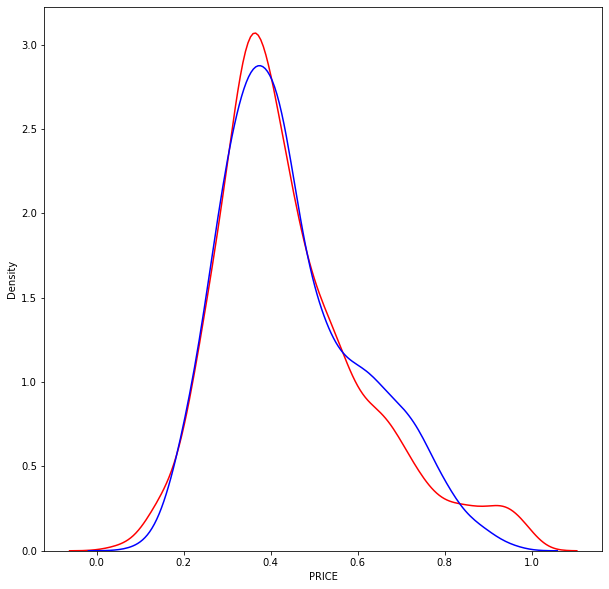

In [44]:
# For Linear Regression

# get predicted y values for X_Test values and store in 'yhat_test' variable

yhat_test_linear = linearRegressionModel.predict(X_test)

# Draw the graphs
DistributionPlot(y_test,yhat_test_linear)

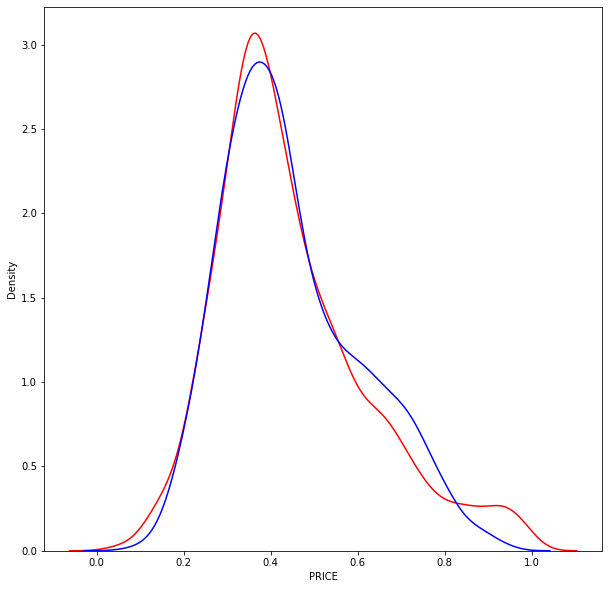

In [45]:
# For Ridge Regression

# get predicted y values for X_Test values and store in 'yhat_test' variable

yhat_test_ridge = ridgeRegressionModel.predict(X_test)

# Draw the graphs
DistributionPlot(y_test,yhat_test_ridge)

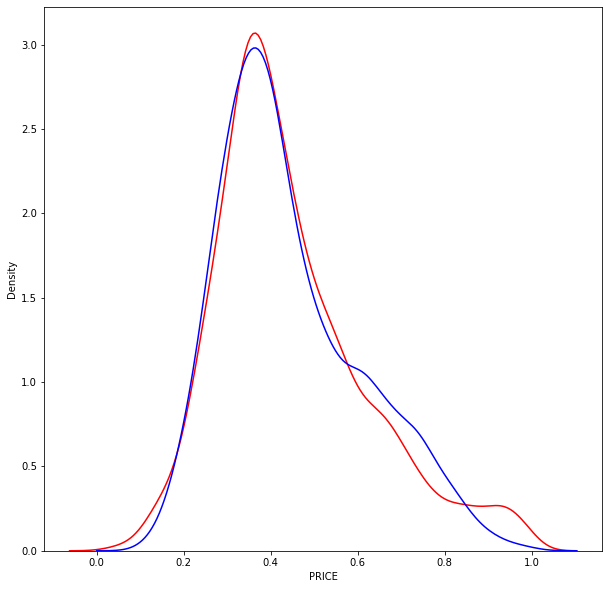

In [46]:
# For MLP Regression

# get predicted y values for X_Test values and store in 'yhat_test' variable

yhat_test_MLP = MLPRegressionModel.predict(X_test)

# Draw the graphs
DistributionPlot(y_test,yhat_test_MLP)